In [ ]:
!pip install transformers datasets sentencepiece accelerate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 25.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import load_dataset
import torch

In [ ]:
model_name = "lmqg/t5-base-squad-qag"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.36k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/20.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [ ]:
# Load and prepare dataset
dataset = load_dataset("lmqg/qag_squad")

Generating train split:   0%|          | 0/16462 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2067 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2429 [00:00<?, ? examples/s]

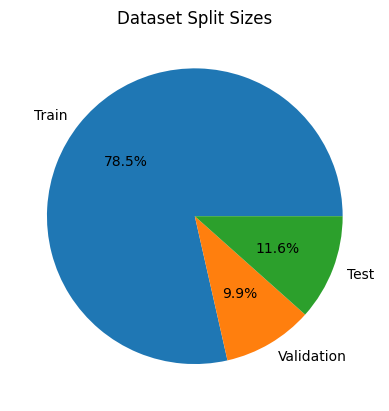

In [ ]:
import matplotlib.pyplot as plt

# Get data point counts for each split
train_size = len(dataset["train"])
validation_size = len(dataset["validation"])
test_size = len(dataset["test"])
total_size = train_size + validation_size + test_size

# Prepare labels and data for the pie chart
split_labels = ["Train", "Validation", "Test"]
split_sizes = [train_size, validation_size, test_size]

# Create the pie chart
plt.pie(split_sizes, labels=split_labels, autopct="%1.1f%%")  # Add percentages
plt.title("Dataset Split Sizes")
plt.show()


In [ ]:
features_train = dataset["train"].features  # Get features from training set

print("Available Features:")
for feature_name, feature_info in features_train.items():
    print(f"- {feature_name} ({feature_info.dtype})")


Available Features:
- answers (list)
- questions (list)
- paragraph (string)
- questions_answers (string)


In [ ]:
def preprocess_data(examples):
    # Preprocess input (context) and target (question and answer pair) for the model
    model_inputs = tokenizer(examples['paragraph'], max_length=512, truncation=True, padding="max_length")

    # Set up the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['questions_answers'], max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_data, batched=True)

Map:   0%|          | 0/16462 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3921: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/2067 [00:00<?, ? examples/s]

Map:   0%|          | 0/2429 [00:00<?, ? examples/s]

In [ ]:
# Import necessary libraries
import random

# Select a random sample from the tokenized datasets
sample_index = random.randint(0, len(tokenized_datasets["train"]) - 1)
sample = tokenized_datasets["train"][sample_index]

# Print the tokenized sample
print("Tokenized Sample:")
print(sample)


Tokenized Sample:
{'answers': ['Lawrence Lessig', 'Stephan Kinsella', 'tangible', 'indefinitely'], 'questions': ['Who is one advocate of copyleft?', 'Who has objected to the idea of IP because "property" implies scarcity?', 'Having no natural scarcity makes IP different from what kind of property?', 'How much can IP be duplicated without diminishing the original?'], 'paragraph': 'Law professor, writer and political activist Lawrence Lessig, along with many other copyleft and free software activists, has criticized the implied analogy with physical property (like land or an automobile). They argue such an analogy fails because physical property is generally rivalrous while intellectual works are non-rivalrous (that is, if one makes a copy of a work, the enjoyment of the copy does not prevent enjoyment of the original). Other arguments along these lines claim that unlike the situation with tangible property, there is no natural scarcity of a particular idea or information: once it exists

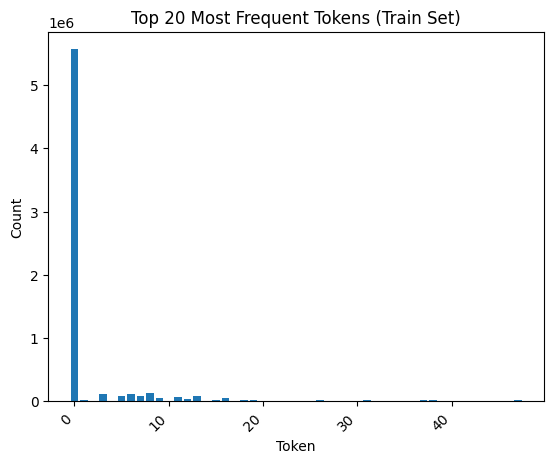

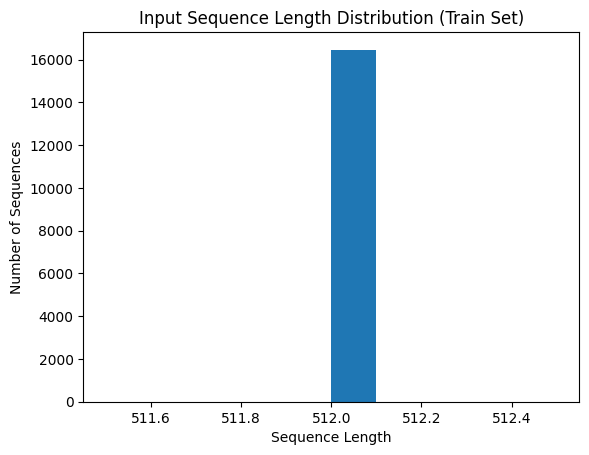

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get tokenized inputs and labels
tokenized_inputs = tokenized_datasets["train"]["input_ids"]
tokenized_labels = tokenized_datasets["train"]["labels"]

# 1. Token Distribution
all_tokens = [token for sample in tokenized_inputs for token in sample]
token_counts = pd.Series(all_tokens).value_counts().sort_values(ascending=False)

plt.bar(token_counts.index[:20], token_counts.values[:20])  # Show top 20 most frequent tokens
plt.xlabel("Token")
plt.ylabel("Count")
plt.title("Top 20 Most Frequent Tokens (Train Set)")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.show()

# 2. Sequence Length Distribution (Input)
sequence_lengths = [len(sample) for sample in tokenized_inputs]
plt.hist(sequence_lengths)
plt.xlabel("Sequence Length")
plt.ylabel("Number of Sequences")
plt.title("Input Sequence Length Distribution (Train Set)")
plt.show()

# (Similar code for target sequence length distribution)

# 3. Special Token Analysis (if applicable)
# ... (calculate frequencies of special tokens)


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",             # Output directory for model checkpoints
    evaluation_strategy="epoch",        # Evaluate each epoch
    learning_rate=2e-5,                 # Learning rate
    per_device_train_batch_size=8,      # Batch size per device during training
    per_device_eval_batch_size=8,       # Batch size for evaluation
    num_train_epochs=3,                 # Number of training epochs
    weight_decay=0.01,                  # Weight decay
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
)

In [ ]:
  # Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.701500,0.903091
2,0.683900,0.897602


In [ ]:
def generate_qa_pairs(context, model, tokenizer, num_pairs=1, max_length=256):
    qa_pairs = []

    current_start = 0
    while current_start < len(context):
        current_end = min(current_start + max_length, len(context))
        chunk = context[current_start:current_end]

        encoding = tokenizer.encode_plus(chunk, max_length=max_length, truncation=True, return_tensors="pt")
        input_ids, attention_mask = encoding["input_ids"], encoding["attention_mask"]

        output_sequences = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            early_stopping=True,
            num_beams=3,
            num_return_sequences=num_pairs,
            no_repeat_ngram_size=2,
            max_length=200,
        )

        for sequence in output_sequences:
            qa_text = tokenizer.decode(sequence, skip_special_tokens=True)
            qa_parts = qa_text.split("[SEP]")
            qa_pairs.append(qa_text)


        current_start = current_end

    return qa_pairs

In [ ]:
context = '''
Arsenal Football Club, based in North London, stands as one of the most iconic and historically significant teams in English football. Established in 1886, Arsenal has cultivated a rich legacy intertwined with triumphs, innovations, and enduring traditions. The club's iconic home ground, the Emirates Stadium, serves as a modern-day colosseum where the team's passionate fanbase, known as the "Gooners," congregates to witness the spectacle of footballing excellence. Arsenal's journey through the decades has been marked by periods of dominance and transition, with notable figures such as Herbert Chapman, Arsène Wenger, and now Mikel Arteta, leaving indelible imprints on its narrative.

Throughout its history, Arsenal has amassed an impressive trophy cabinet, including numerous league titles, FA Cups, and continental honors. The club's storied rivalry with fellow London giants, Tottenham Hotspur, adds spice to every encounter, encapsulating the fervor of the North London derby. Arsenal's style of play, often characterized by fluid attacking football and a commitment to nurturing young talent, has endeared them to football purists worldwide.

Off the pitch, Arsenal remains a beacon of community engagement and social responsibility. Through initiatives such as the Arsenal Foundation, the club channels its resources to support various charitable causes, embodying the ethos of giving back to the community that has steadfastly supported it through thick and thin. Moreover, Arsenal's renowned academy system continues to produce prodigious talents, fostering a culture of development and continuity within the club.

However, Arsenal's recent years have been marked by a transitional phase, grappling with the challenges of adapting to a rapidly evolving football landscape. Despite periodic setbacks, the club's unwavering commitment to its core values of integrity, innovation, and excellence provides a beacon of hope for the future. With a renewed sense of purpose under the stewardship of Mikel Arteta and bolstered by a blend of seasoned veterans and promising youngsters, Arsenal looks poised to reclaim its status among English football's elite, ensuring that the legacy of the red and white remains etched in the annals of footballing history for generations to come.
'''

In [ ]:
def generate_qa_pairs(context, model, tokenizer, num_pairs=1, max_length=256):
    qa_pairs = []

    current_start = 0
    # Get the device of the model
    device = next(model.parameters()).device
    while current_start < len(context):
        current_end = min(current_start + max_length, len(context))
        chunk = context[current_start:current_end]

        encoding = tokenizer.encode_plus(chunk, max_length=max_length, truncation=True, return_tensors="pt")
        input_ids, attention_mask = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)

        output_sequences = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            early_stopping=True,
            num_beams=3,
            num_return_sequences=num_pairs,
            no_repeat_ngram_size=2,
            max_length=200,
        )

        for sequence in output_sequences:
            qa_text = tokenizer.decode(sequence, skip_special_tokens=True)
            qa_parts = qa_text.split("[SEP]")
            qa_pairs.append(qa_text)

        current_start = current_end

    return qa_pairs

qa_pairs = generate_qa_pairs(context, model, tokenizer, num_pairs=1, max_length=256)

In [ ]:
qa_pairs

['one of the most iconic and historically significant teams in English football., Arsenal Football Club, based in North London | question: When was the Arsenal football club established?, answer: 1886',
 'the "Gooners" are a modern-day colosseum where Arsenal\'s passionate fanbase congregates to witness the spectacle of footballing excellence. The Arsenal team\'S iconic home ground, the Emirates Stadium, serves as an iconic modern day colludeum.',
 'by periods of dominance and transition, with notable figures such as Herbert Chapman, Arsène Wenger, and now Mikel Arteta, leaving indelible imprints on its narrative., marking its history, Arsenal has amassed an impressive trophy cabinet,',
 "ncluding numerous league titles, FA Cups, and continental honors., Arsenal's storied rivalry with fellow London giants: Tottenham Hotspur, adds spice to every encounter, encapsulating the fervor of the North London derby. | question: What Arsenal style of play is often chaste?, answer: Arsenals style 

In [ ]:
def clean_qa_pairs(qa_pairs):
    cleaned_qa_pairs = []
    for pair in qa_pairs:
        parts = pair.split(", answer: ", 1)
        if len(parts) > 1:
            question = parts[0].split("question: ")[1]
            answer = parts[1].split("|")[0].capitalize()
            cleaned_qa_pairs.append({"question": question, "answer": answer})
    return cleaned_qa_pairs

In [ ]:
cleaned_pairs = clean_qa_pairs(qa_pairs)
cleaned_pairs

[{'question': 'When was the Arsenal football club established?',
  'answer': '1886'},
 {'question': 'What Arsenal style of play is often chaste?',
  'answer': 'Arsenals style of play'},
 {'question': 'What does Arsenal remain an example of off the pitch?',
  'answer': ' a beacon of community engagement and social responsibility.'},
 {'question': 'What is the Arsenal Foundation?',
  'answer': 'The club channels its resources to support various charitable causes, embodying the ethos of giving back to the community that has steadfastly supported it through thick and thin.'}]

In [ ]:
#conversion to a csv
import pandas as pd
def conversiontocsv(cleaned_pairs):
  df=pd.read_json(str({"data":cleaned_qa_pairs}))
  csv_file_download=df.to_csv("csv_cleaned_qa_pairs.csv")
  return csv_file_download